In [ ]:
## Implementation for 

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import pandas as pd
import os
import skimage 
from skimage import io 
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, WeightedRandomSampler
import torch.nn.functional as F
from torchvision import models
from collections import defaultdict
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import matplotlib

cuda:0


In [15]:
# Remove wrong values in small image (due to interpolation)
import cv2

def resize(img, height, width,
           interpolation=cv2.INTER_NEAREST):
    #use interpolation=cv2.INTER_CUBIC for image 
    """
    Resize an image using OpenCV.
    Note that cv2.resize dsize is (height, width).

    :param img: Input image
    :param height: height
    :param width: width
    :param interpolation: cv2 interpolation type
    :return: resized image
    """
    return cv2.resize(img, (height, width), interpolation=interpolation)


def one_hot_conversion(mask):

    """ Expects input to be in shape h, w, c 
    """
    resized_mask = mask[:,:,0]
    num_classes = 6
    one_hot_correct = np.zeros((resized_mask.shape[0], resized_mask.shape[1], num_classes))

    for class_ in np.unique(resized_mask):
        one_hot_correct[:, :, class_][resized_mask == class_] = 1
#     print("one_hot_correct.shape", one_hot_correct.shape)
    return one_hot_correct # h , w , num_classes


mask = skimage.io.MultiImage('/project/data/train_label_masks/0018ae58b01bdadc8e347995b69f99aa_mask.tiff')[-1]
resized_mask = resize(mask, 224,224)

one_hot_correct = one_hot_conversion(resized_mask)
print(one_hot_correct.shape)


def mask_from_one_hot(one_hot_mask):
    """ Expects input to be in shape h, w, c
    """
    original_mask = np.argmax(one_hot_mask, axis=2)
    return original_mask

recovered_mask = mask_from_one_hot(one_hot_correct)

(224, 224, 6)


In [16]:
class ImageWithMaskDataset(Dataset):
    
    def __init__(self, csv_filePath, image_dir, mask_dir, one_hot_mask=False, transform=None):
        train_df = pd.read_csv(csv_file_path)
                
        
#         masks = os.listdir(mask_dir)
#         masks_df = pd.Series(masks).to_frame()
#         masks_df.columns = ['mask_file_name']
#         masks_df['image_id'] = masks_df.mask_file_name.apply(lambda x: x.split('_')[0])
#         train_df = pd.merge(train_df, masks_df, on='image_id', how='outer')
#         del masks_df
#         print(f"There are {len(train_df[train_df.mask_file_name.isna()])} images without a mask.")

#         ## removing items where image mask is null
#         train_df = train_df[~train_df.mask_file_name.isna()]        
        
#         images = os.listdir(image_dir)
#         images_df = pd.Series(images).to_frame()
#         images_df.columns = ['image_file_name']
#         images_df['image_id'] = images_df.image_file_name.apply(lambda x: x.split('.')[0])
#         train_df = pd.merge(train_df, images_df, on='image_id', how='outer')
#         del images_df 
#         print(f"There are {len(train_df[train_df.image_file_name.isna()])} image_ids without a image.")
        
#         ## Remove image_id not present in image_dir
#         train_df = train_df[~train_df.image_file_name.isna()]                

        ## Remove image_id not for Karolinska
        train_df = train_df[train_df.data_provider=='radboud']

        self.data_frame = train_df.copy()
        
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.one_hot_mask = one_hot_mask
        print('Creating dataset with {} examples'.format(len(self.data_frame)))
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        image_id = self.data_frame.iloc[idx]['image_id']
        image_file_path = os.path.join(self.image_dir, image_id + ".tiff")
        image = skimage.io.MultiImage(image_file_path)[-1]
        image = resize(image, 224,224,interpolation=cv2.INTER_CUBIC)                
        image = image.transpose((2, 0, 1))  
        
        try:
            mask_file_path = os.path.join(self.mask_dir, image_id + "_mask.tiff")
            mask = skimage.io.MultiImage(mask_file_path)[-1] # h, w, c
            mask = resize(mask, 224,224)
            if self.one_hot_mask:
                mask = one_hot_conversion(mask)
                mask = mask.transpose((2, 0, 1))        
            else:
                mask = mask.transpose((2, 0, 1))        
                mask = mask[0,:,:]
        except:
            return None
        
        isup_grade = self.data_frame.iloc[idx]['isup_grade']
        
        return (image, mask, isup_grade)


In [17]:
image_dir = '/project/data/train_images'
mask_dir = '/project/data/train_label_masks'
csv_file_path = '/home/abharani/data/train_filtered.csv'

dataset_with_mask = ImageWithMaskDataset(csv_file_path, image_dir, mask_dir,one_hot_mask=False)

for i in range(len(dataset_with_mask)):
    sample = dataset_with_mask[i]
    print(i, sample[0].shape, sample[1].shape)
    break

Creating dataset with 5060 examples
0 (3, 224, 224) (224, 224)


In [18]:
# train_df = pd.read_csv('/home/abharani/data/train_filtered.csv')
# train_df[train_df['data_provider']=='radboud']

### Convert mask into pixel wise one hot encoding 
def pre_process_mask(mask):
    pass
    
    # first channel 0 - 1, pixel wise one hot encoding

In [19]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

#### Perform Test, Train and Valid Split 

In [20]:
def train_val_dataset(dataset, val_split=0.25, generate_small=False):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets_created = {}
    if generate_small:
        print("Generating Small Train, Test Dataset")
        datasets_created['train'] = Subset(dataset, train_idx[0:200])
        datasets_created['test'] = Subset(dataset, val_idx[0:50])
    else:
        datasets_created['train'] = Subset(dataset, train_idx)
        datasets_created['test'] = Subset(dataset, val_idx)        
    return datasets_created



dataset_final = {}
datasets_created_trial_1 = train_val_dataset(dataset_with_mask,val_split=0.10,generate_small=False)
datasets_created_trial_2 = train_val_dataset(datasets_created_trial_1['train'],val_split=0.25,generate_small=False)

dataset_final['test'] = datasets_created_trial_1['test']
dataset_final['train'] = datasets_created_trial_2['train']
dataset_final['val'] = datasets_created_trial_2['test']

print("Dataset set size {}".format(len(dataset_with_mask)))
print("Train set size {}".format(len(dataset_final['train'])))
print("Validation set size {}".format(len(dataset_final['val'])))
print("Test set size {}".format(len(dataset_final['test'])))

Dataset set size 5060
Train set size 3415
Validation set size 1139
Test set size 506


In [21]:
# for i, sample in enumerate(dataset_final['train']): 
#     print(sample[0].shape, sample[1].shape)
#     if i==2:
#         break

In [22]:
# from collections import defaultdict 

# count_dict = defaultdict(int)
# target_list = []

# #Generate target_list of all labels and count dict of all classes

# for i, sample in enumerate(dataset_final['train']): 
#     label = sample[2]
#     count_dict[label] += 1
#     target_list.append(int(label))
    
# print("Distribution of classes: \n", count_dict)

# class_count = [i for i in count_dict.values()]
# class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
# print("Class weights : \n", class_weights)

# target_list = torch.tensor(target_list)
# target_list = target_list[torch.randperm(len(target_list))]
# class_weights_all = class_weights[target_list]

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=len(class_weights_all),
#     replacement=True
# )

In [23]:
train_loader = DataLoader(dataset_final['train'],batch_size=32, collate_fn=collate_fn, shuffle = True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset_final['val'],batch_size=32,  collate_fn=collate_fn,num_workers=4, pin_memory=True)

dataloaders  = {'train': train_loader, 'val': val_loader}

dataset_sizes = {x: len(dataset_final[x]) for x in dataset_final.keys()}

In [24]:
# mask = None
# for i, batch in enumerate(train_loader):
    
#     image, mask, isup_grade = batch[0], batch[1], batch[2]
#     print(i, image.shape, mask.shape)
 
#     break

In [25]:
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.conv_ultimate = nn.Conv2d(n_class,1,kernel_size=(1,1),bias=True)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)       # (N,6,224,224) 
        
        out_ultimate = self.conv_ultimate(out)
        return out_ultimate
#         return out
    

In [30]:
x = torch.zeros((5, 3, 224, 224), dtype=torch.float32)  # minibatch size 64, image size [3, 32, 32]
base_model = models.resnet18(pretrained=False)
model = ResNetUNet(6)
scores = model(x)
print(scores.size())  # you should see [5,1,224,224]
scores = torch.squeeze(scores)
print(scores.size())

torch.Size([5, 1, 224, 224])
torch.Size([5, 224, 224])


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = models.resnet18(pretrained=False)
base_model = base_model.to(device)
model = ResNetUNet(6)
model = model.to(device,dtype = torch.float32)


def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for batch in dataloaders[phase]:
                inputs, labels, label = batch[0],batch[1],batch[2] 
                inputs = inputs.to(device, dtype = torch.float32)
#                 inputs = torch.reshape(inputs,(inputs.shape[0],inputs.shape[3],inputs.shape[1],inputs.shape[2])) #  inputs.reshape [N, C, W, H]
#                 print(inputs.shape)
                
                labels = labels.to(device, dtype = torch.float32)    
#                 labels = torch.reshape(labels,(labels.shape[0],labels.shape[3],labels.shape[1],labels.shape[2])) #  inputs.reshape [N, C, W, H]
#                 print(labels.shape)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
#                     outputs = torch.squeeze(outputs) # added now
#                     print("outputs shape ", outputs.shape, "labels shape ", labels.shape)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [34]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = ResNetUNet(num_class).to(device)

# freeze backbone layers
# Comment out to finetune further
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)

cuda:0
Epoch 0/14
----------
LR 0.0001


RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 11.17 GiB total capacity; 10.23 GiB already allocated; 247.69 MiB free; 10.61 GiB reserved in total by PyTorch)

# Saving the model

In [ ]:
# torch.save(model.state_dict(), '/home/abharani/data/ResUNet_v1')

In [ ]:
# model = TheModelClass(*args, **kwargs)

### Load the model

In [19]:
# model = TheModelClass(*args, **kwargs)
model = ResNetUNet(6).to(device)
# model= MyModel()
model.load_state_dict(torch.load('/home/abharani/data/ResUNet_v1'))
# model.eval()

<All keys matched successfully>

In [22]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255)
    return image

def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    return np.squeeze(mask)

def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks, _ = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    plt.figure(figsize=(20,10))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
        
         plt.imshow(mask,cmap=cmap, interpolation='nearest',)
    plt.show()

In [38]:
#### prediction

import math

model.eval()   # Set model to evaluate mode

test_loader = DataLoader(dataset_final['test'],batch_size=32,  collate_fn=collate_fn,num_workers=4, pin_memory=True)

t_images, t_masks, isup_grade  = next(iter(test_loader))
t_images = t_images.to(device, dtype = torch.float32)
t_masks = t_masks.to(device, dtype = torch.float32)
# t_images = torch.reshape(t_images,(t_images.shape[0],t_images.shape[3],t_images.shape[1],t_images.shape[2])) #  inputs.reshape [N, C, W, H]
# t_masks = torch.reshape(t_masks,(t_masks.shape[0],t_masks.shape[3],t_masks.shape[1],t_masks.shape[2])) #  inputs.reshape [N, C, W, H]


t_preds = model(t_images)
# t_preds = torch.sigmoid(t_preds)
# pred = pred.data.cpu().numpy()
print(t_preds.shape)

# Change channel-order and make 3 channels for matplot
# input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# # Map each channel (i.e. class) to each color
# target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
# pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

# helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

torch.Size([32, 6, 224, 224])


In [39]:
t_preds = t_preds.to(device)
t_masks = t_masks.to(device)

In [40]:
isup_grade[0]

tensor(0.)

In [41]:
print(t_preds.shape, t_masks.shape)

torch.Size([32, 6, 224, 224]) torch.Size([32, 6, 224, 224])


In [42]:
predicted_mask_0 = torch.argmax(t_preds[0], dim=0)
original_mask_0 = torch.argmax(t_masks[0], dim=0)
print(predicted_mask_0.shape, original_mask_0.shape)

# t_pred = mask_convert(t_preds[0])
# t_pred = np.argmax(t_pred, axis=2)
# plt.figure(figsize=(20,20))
# plt.imshow(t_pred)
# t_pred.shape

torch.Size([224, 224]) torch.Size([224, 224])


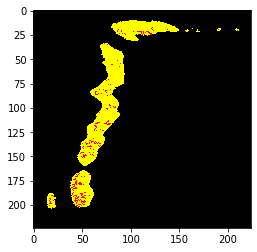

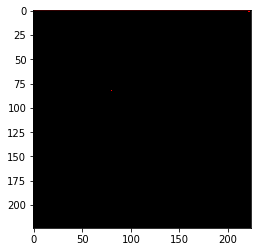

In [44]:
plt.imshow(original_mask_0.clone().cpu().numpy(),cmap=cmap, interpolation='nearest')
plt.show()
plt.imshow(predicted_mask_0.clone().cpu().numpy(),cmap=cmap, interpolation='nearest')
plt.show()

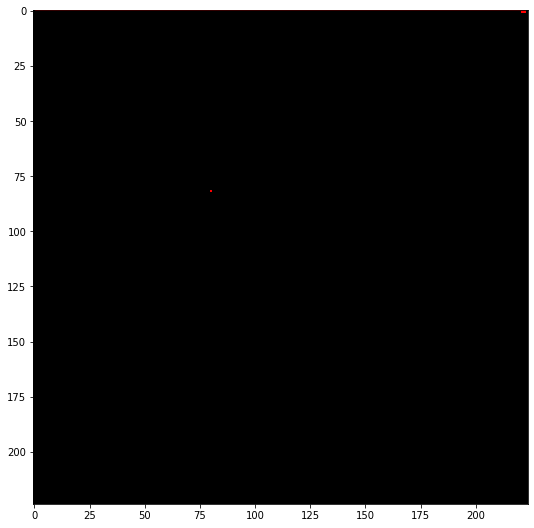

In [33]:
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.figure(figsize=(20,20))
plt.title("Predict Mask")
no_ = 1
for idx in range(0,no_):
#      t_pred = mask_convert(t_preds[idx])
     t_pred = mask_convert(predicted_mask)
     plt.subplot(2,no_,idx+no_+1)
     plt.imshow(t_pred,cmap=cmap, interpolation='nearest',)

plt.show()          